بِسْمِ اللهِ الرَّحْمَنِ الرَّحِيْمِ

![image info](https://www.bluebi.com/wp-content/uploads/2023/04/Text-analysis-Blue-BI.jpg)

# Objectives
- Get translation with scraping from https://quran.kemenag.go.id/quran/per-ayat/surah/
- Wordcloud from Al-Qur'an translating in Indonesian language
- and other NLP analysis


<b>Disclaimer :</b>
<p>Hanya sebatas mengambil data mentah dari scraping arti Al Qur'an, pada dasarnya Al Qur'an tidak dapat diartikan begitu saja, setiap ayat ada waktu, tempat, dan kondisi ketika ayat tersebut diturunkan, mudah-mudahan analisa bisa dikembangkan dengan memakai data yang lebih lengkap, terimakasih.</p>
<p><i>Only limited to taking raw data from scraping the meaning of the Qur'an, basically the Qur'an cannot be interpreted just like that, each verse has a time, place, and conditions when the verse was revealed, hopefully the analysis can be developed by using more complete data, thank you.</i></p>

## Import required libraries

In [1]:
"""
text analysis libraries
"""
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
from collections import defaultdict, Counter
import csv
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from nltk.corpus import stopwords
from spacy.lang.id.stop_words import STOP_WORDS
import json
import requests
import wikipedia
from io import BytesIO
from wordcloud import WordCloud, STOPWORDS
import random
from PIL import Image
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

"""
scraping libraries
"""
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Scraping time
Kita akan melakukan scraping pada url <a href="https://quran.kemenag.go.id/quran/per-ayat/surah/">https://quran.kemenag.go.id/quran/per-ayat/surah/</a> untuk mendapatkan arti surat Al-Qur'an. Mendapatkan beberapa data seperti:
- list nama surat
- panjang surat
- arti surat

<i>We will scrape the URL https://quran.kemenag.go.id/quran/per-ayat/surah/ to obtain the meaning of the surahs of the Quran. We will obtain several data items, such as:</i>
- <i>list of surah names</i>
- <i> surah length</i>
- <i>surah meaning</i>

In [ ]:
### get surah list
driver = webdriver.Chrome()

driver.get("https://quran.kemenag.go.id/quran/per-ayat/surah/1?from=1&to=7")

from_val =driver.find_elements(by=By.NAME, value="surah")
ea1 = Select(from_val[0]).options

surat_lst = [i.get_attribute("text") for i in ea1]
driver.quit()

In [ ]:
### function get length surah
def get_url1(text):
    driver = webdriver.Chrome()
    driver.get(text)
    driver.implicitly_wait(0.5)

    from_val =driver.find_elements(by=By.NAME, value="to")
    try:
        ea1 = Select(from_val[0]).options
    except AttributeError:
        ea1 = Select(from_val).options
    except:
        ea1 = from_val
    len_surat = len([i.get_attribute("value") for i in ea1])
    driver.quit()
    return len_surat

### function get translation
def get_url2(urutan, len_surat):
    url = "https://quran.kemenag.go.id/quran/per-ayat/surah/{}?from=1&to={}".format(urutan, len_surat)
    driver = webdriver.Chrome()
    driver.get(url)
    
    prev_height = -1 
    max_scrolls = 999
    scroll_count = 0

    while scroll_count < max_scrolls:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)  # give some time for new results to load
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == prev_height:
            break
        prev_height = new_height
        scroll_count += 1
    
    elements = WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CLASS_NAME, "surah-translate")))

    data = [i.text for i in elements]
    driver.quit()
    return data

In [ ]:
### scrape data

data = dict() ## save data to dict

for i, j in enumerate(surat_lst):
    url = "https://quran.kemenag.go.id/quran/per-ayat/surah/{}".format(str(i+1))
    len_surat = get_url1(url)
    data1 = get_url2(str(i+1), str(len_surat))

    data[j] = data1

In [ ]:
"""
membuat dataframe dengan memisahkan antara nama surat, latin, dan arti.

create a dataframe by separating the letter names, Latin, and meaning.
"""
nama_surat, latin, indo = [], [], []

for i in range(0, 114, 1):
    for key, val in enumerate(df.iloc[i][1]):
        if key < len(df.iloc[i][1])/2:
            nama_surat.append(df.iloc[i][0])
        if key % 2 == 0:
            latin.append(val)
        else:
            indo.append(val)


"""
simpan dataframe sebagai file pickle.

save the dataframe as a pickle file.
"""
pd.DataFrame(data={
    'surat': nama_surat,
    'latin': latin,
    'arti': indo
}).to_pickle('raw_df.pkl')

# Preprocessing
Preprocessing text seperti <a href="https://www.datacamp.com/blog/what-is-tokenization">tokenizing</a>, <a href="https://towardsdatascience.com/text-normalization-7ecc8e084e31/">text normalization</a>, <a href="https://kavita-ganesan.com/what-are-stop-words/">stopword removing</a>, dan <a href="https://medium.com/@martinthetechie/nlp-guide-stemming-lemmatization-426f7ee2dbd6">stemming/lemmatization</a>. Sebelum melakukan hal tersebut, ada beberapa kata yang harus kita perbaiki dahulu untuk tidak mengurangi arti ketika melakukan text preprocessing, contohnya "Al-Qur’an", "alqur’an", kita akan merubahnya menjadi "alquran".

<i>Text preprocessing such as <a href="https://www.datacamp.com/blog/what-is-tokenization">tokenizing</a>, <a href="https://towardsdatascience.com/text-normalization-7ecc8e084e31/">text normalization</a>, <a href="https://kavita-ganesan.com/what-are-stop-words/">stopword removing</a>, and <a href="https://medium.com/@martinthetechie/nlp-guide-stemming-lemmatization-426f7ee2dbd6">stemming/lemmatization</a>. Before doing this, there are some words that we must correct first to not reduce the meaning when doing text preprocessing, for example "Al-Qur'an", "alqur'an", we will change it to "alquran".</i>

In [2]:
df = pd.read_pickle('raw_df.pkl')
df.head(3)

,surat,latin,arti
0,1. Al-Fātiḥah,Bismillāhir-raḥmānir-raḥīm(i).,Dengan nama Allah Yang Maha Pengasih lagi Maha...
1,1. Al-Fātiḥah,Al-ḥamdu lillāhi rabbil-‘ālamīn(a).,"Segala puji bagi Allah, Tuhan1) semesta alam"
2,1. Al-Fātiḥah,Ar-raḥmānir-raḥīm(i).,"Yang Maha Pengasih lagi Maha Penyayang,"


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4935 entries, 0 to 4934
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   surat   4935 non-null   object
 1   latin   4935 non-null   object
 2   arti    4935 non-null   object
dtypes: object(3)
memory usage: 115.8+ KB


In [3]:
"""
replace "Al-Qur’an" and "alqur’an" to "alquran",
remove pattern "{number})", ex: Bimbinglah kami ke jalan yang lurus,3), 
change to lower case, and other transforming method.
"""
punct_custom = string.punctuation + "“"

pattern = r"\d\)"  # \d = digit (0‑9)

pattern1 = r"allah" 

df['arti_1'] = df['arti'].str.replace("Al-Qur’an", "alquran")
df['arti_1'] = df['arti_1'].str.replace("alqur’an", "alquran")
df['arti_1'] = df['arti_1'].str.replace("fir‘aun", "firaun")

## change text to lower case & remove white space
df['arti_1'] = df['arti_1'].apply(lambda x: re.sub(pattern, "", x).lower().strip())

## remove number on text
df['arti_1'] = df['arti_1'].apply(lambda x: re.sub(r"\d+", "", x))

## remove punctuation
df['arti_1'] = df['arti_1'].apply(lambda x: x.translate(str.maketrans("","",punct_custom)))

## change text 'allah' with 'Allah'
df['arti_1'] = df['arti_1'].apply(lambda x: re.sub(pattern1, "Allah", x))

## Word Tokenizing
<p>Trasnform kalimat menjadi list kata. Ex: "saya bermain bola" => ["saya", "bermain", "bola"]</p>

<p><i>Transform a sentence into a list of words. Ex: "I play ball" => ["I", "play", "ball"]</i></p>

In [4]:
df['word_tokenize'] = df['arti_1'].apply(lambda x: nltk.tokenize.word_tokenize(x))

## Stopword
<p>Penggunaan stopword yaitu untuk mengurangi kata yang tidak terlalu penting, sehingga dapat menemukan makna apa yang terkandung pada sebuah kalimat/teks. Contohnya "bagaimana budidaya ikan", kata "bagaimana" termasuk ke dalam stopword. Tetapi penggunaan stopword juga dapat berdampak negatif ketika menangani permasalahan analisis sentimen, contoh: "Sudah saya katakan bahwa dia tidak senang", hasilnya menjadi ['katakan', 'senang']. Output menjadi positif, padahal negatif.</p>
<p>Karena analisis kali ini hanya ingin mengetahui kata apa saja yang terkandung dalam Al-Qur'an berdasarkan data pada sumber yang telah disebutkan, maka kita dapat menggunakan stopword. Tetapi jika analisis sampai pada makna ayat, mungkin harus dipertimbangkan kembali.</p>
<br>
<p><i>Stopwords are used to eliminate unnecessary words, allowing for the deeper meaning of a sentence/text. For example, "how to cultivate fish," the word "how" is considered a stopword. However, stopwords can also have negative consequences when analyzing sentiment. For example, "I told you he wasn't happy," the result becomes ['say', 'happy']. The output appears positive, even though it's actually negative.</i></p>
<p><i>Since this analysis only seeks to determine the words contained in the Quran based on data from the sources mentioned, we can use stop words. However, if the analysis extends to the meaning of the verses, it may require further consideration.</i></p>

In [9]:
"""
kita menggunakan beberapa source list stopword
"""
sw1 = []
with open('DataSource/StopWords/stopwords-idn-2016.txt', 'r') as fd: ### https://github.com/masdevid/ID-Stopwords/blob/master/id.stopwords.02.01.2016.txt
    reader = csv.reader(fd)
    for row in reader:
        sw1.append(row[0])

sw2 = []
with open('DataSource/Lemmatize/3/stopword.txt', 'r') as fd: ### https://codeload.github.com/kumparan/nlp-id/zip/refs/heads/master
    reader = csv.reader(fd)
    for row in reader:
        sw2.append(row[0])

sw3 = []
with open('DataSource/Lemmatize/2/combined_stop_words.txt', 'r') as fd:  ### https://codeload.github.com/louisowen6/NLP_bahasa_resources/zip/refs/heads/master
    reader = csv.reader(fd)
    for row in reader:
        sw3.append(row[0])

sw4 = StopWordRemoverFactory().get_stop_words() ### Sastrawi stopwords

sw5 = stopwords.words('indonesian') ### nltk stopwords

sw6 = []
with open('DataSource/StopWords/1/indonesian.txt', 'r') as fd: ### kaggle
    reader = csv.reader(fd)
    for row in reader:
        sw6.append(row[0])

sw7 = list(STOP_WORDS) ### spacy 

# Combine the lists and convert to a set to remove duplicates
combined_set = set(sw1 + sw2 + sw3 + sw4 + sw5 + sw6 + sw7)

# Convert the set back to a list if a list is required
stopwords_combine = list(combined_set)

# save as txt file for later
with open('sw_gout.txt', 'w') as f:
    for item in stopwords_combine:
        f.write(f"{item}\n")

In [10]:
## new feature (word with no stopwords)
def stopwords_removal(words,stopword):
    return [word for word in words if word not in stopword]

df['after_stopwords'] = df['word_tokenize'].apply(lambda x: stopwords_removal(x, stopwords_combine))

## Text normalization
<p>Text normalization atau noise removal, proses transformasi bahasa tidak baku menjadi baku, dan juga singkatan. Ex: "utk" => "untuk".</p>

<p><i>Text normalization, or noise removal, is the process of transforming non-standard language into standard language, as well as abbreviations. Ex: "utk" => "untuk".</i></p>

In [11]:
norm_idn = pd.read_csv("https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv")
norm_idn.head(3)

def norm_removal(doc,slang_word):
    for index in  range(0,len(doc)-1):
        index_slang = slang_word.slang==doc[index]
        formal = list(set(slang_word[index_slang].formal))
        if len(formal)==1:
            doc[index]=formal[0]
    return doc

df['after_normalization'] = df['after_stopwords'].apply(lambda x: norm_removal(x, norm_idn))

In [12]:
## save for later
df.to_pickle('mediumraw_df1.pkl')

## Stemming/Lemmatization
<p>Kesempatan kali ini kita akan menggunakan Lemmatization, <a href="https://www.ibm.com/think/topics/stemming-lemmatization">cekidot</a> untuk penjelasan stemming vs lemmatization.</p>
<p><i>This time we will use Lemmatization, <a href="https://www.ibm.com/think/topics/stemming-lemmatization">cekidot</a> for an explanation of stemming vs lemmatization.</i></p>

In [14]:
"""
fungsi lemmatization dari module nlp-id

lemmatization function of nlp-id module
"""
class Lemmatizer:
    def __init__(self):
        with open('lemmatizerIndo/3/nlp_id/data/root-word.txt') as f:
            self.root_word = set(f.read().splitlines())
        with open('lemmatizerIndo/3/nlp_id/data/lemma_dict.json') as file:
            self.lemma_dict = json.load(file)

    def stem1(self, word):
        if word.endswith(("lah", "kah", "pun")):
            return word[:-3]
        else:
            return word

    def stem2(self, word):
        if word.startswith("ku"):
            return word[2:]
        elif word.startswith("kau"):
            return word[3:]
        else:
            return word

    def stem3(self, word):
        if word.endswith(("ku", "mu")):
            return word[:-2]
        elif word.endswith("nya"):
            return word[:-3]
        else:
            return word

    def stem4(self, word):
        if word.endswith("kan"):
            return [word[:-3], word[:-2]]
        elif word.endswith("an"):
            return word[:-2]
        elif word.endswith("isasi"):
            return word[:-5]
        elif word.endswith("i"):
            return word[:-1]
        elif word.endswith("isme"):
            return word[:-4]
        else:
            return word

    def stem5(self, word):
        if word.startswith(("di", "ke", "se")):
            return word[2:]
        else:
            return word

    def lemmatize(self, text):
        final_result = ""
        suffix = set(["lah", "kah", "pun", "ku", "mu", "nya"])
        text = text.lower()
        text = re.sub("[^a-zA-Z0-9-]+", " ", text)
        for word in text.split():
            result = word.lower()
            if word.isdigit() or len(word) <= 3 or word in self.root_word:
                result = word.lower()
            elif word in self.lemma_dict:
                result = self.lemma_dict[word]
            else:
                word1 = self.stem1(word)
                word2 = self.stem2(word)
                word13 = self.stem3(word1)
                word134 = self.stem4(word13)
                word25 = self.stem5(word2)
                if word1 in self.root_word:
                    result = word1
                elif word1 in self.lemma_dict:
                    result = self.lemma_dict[word1]
                elif word2 in self.root_word:
                    result = word2
                elif word2 in self.lemma_dict:
                    result = self.lemma_dict[word2]
                elif word13 in self.root_word:
                    result = word13
                elif word13 in self.lemma_dict:
                    result = self.lemma_dict[word13]
                elif len(word134) > 0:
                    if isinstance(word134, list):
                        for w in word134:
                            if w in self.root_word:
                                result = w
                            elif w in self.lemma_dict:
                                result = self.lemma_dict[w]
                    elif word134 in self.root_word:
                        result = word134
                    elif word134 in self.lemma_dict:
                        result = self.lemma_dict[word134]
                if result == word.lower():
                    if word25 in self.root_word:
                        result = word25
                    elif word25 in self.lemma_dict:
                        result = self.lemma_dict[word25]
                    else:
                        word12 = self.stem2(word1)
                        word125 = self.stem1(word25)
                        if word12 in self.root_word:
                            result = word12
                        elif word12 in self.lemma_dict:
                            result = self.lemma_dict[word12]
                        elif word125 in self.root_word:
                            result = word125
                        elif word125 in self.lemma_dict:
                            result = self.lemma_dict[word125]
                        else:
                            word123 = self.stem3(word12)
                            word1234 = self.stem4(word123)
                            word1235 = self.stem5(word123)
                            if word123 in self.root_word:
                                result = word123
                            elif word123 in self.lemma_dict:
                                result = self.lemma_dict[word123]
                            elif len(word1234) > 0:
                                if isinstance(word1234, list):
                                    for w in word1234:
                                        if w in self.root_word:
                                            result = w
                                        elif w in self.lemma_dict:
                                            result = self.lemma_dict[w]
                                elif word1234 in self.root_word:
                                    result = word1234
                                elif word1234 in self.lemma_dict:
                                    result = self.lemma_dict[word1234]
                            if result == word.lower():
                                if word1235 in self.root_word:
                                    result = word1235
                                elif word1235 in self.lemma_dict:
                                    result = self.lemma_dict[word1235]
                                else:
                                    word12345 = self.stem4(word1235)
                                    if len(word12345) > 0:
                                        if isinstance(word12345, list):
                                            for w in word12345:
                                                if w in self.root_word:
                                                    result = w
                                                elif w in self.lemma_dict:
                                                    result = self.lemma_dict[
                                                        w
                                                    ]
                                        elif word12345 in self.root_word:
                                            result = word12345
                                        elif word12345 in self.lemma_dict:
                                            result = self.lemma_dict[
                                                word12345
                                            ]
                                    # kepada-Nya --> kepada
                                    # anggota-anggota --> anggota
                                    if result == word.lower() and "-" in word:
                                        split_word = word.split("-")
                                        lemma_list = [
                                            self.lemma_dict.get(i, i)
                                            for i in split_word
                                        ]
                                        if (
                                            len(set(lemma_list)) == 2
                                            and (
                                                split_word[1] in suffix
                                                or self.stem3(split_word[1])
                                                == split_word[0]
                                                or self.stem3(
                                                    self.stem5(split_word[1])
                                                )
                                                == split_word[0]
                                            )
                                        ) or len(set(lemma_list)) == 1:
                                            if (
                                                lemma_list[0]
                                                in self.root_word
                                            ):
                                                result = lemma_list[0]
                                        elif len(set(lemma_list)) == 2 and (
                                            self.stem2(split_word[0])
                                            == split_word[1]
                                            and lemma_list[1]
                                            in self.root_word
                                        ):
                                            result = lemma_list[1]
            final_result += " {}".format(result)
        return final_result.strip()


In [15]:
lemma = Lemmatizer()

df['after_lemma'] = df['after_normalization'].apply(lambda x: " ".join([lemma.lemmatize(i) for i in x]))

### save for analysis
df.to_pickle('df_ayat1.pkl')

# Now we go to exploratory data analysis
<p>Waktunya kita melihat hasil dari preprocessing yang telah dilakukan, lesgoo</p>

## Frequencies

Text(0.5, 1.0, 'Distribusi banyaknya karakter pada setiap ayat')

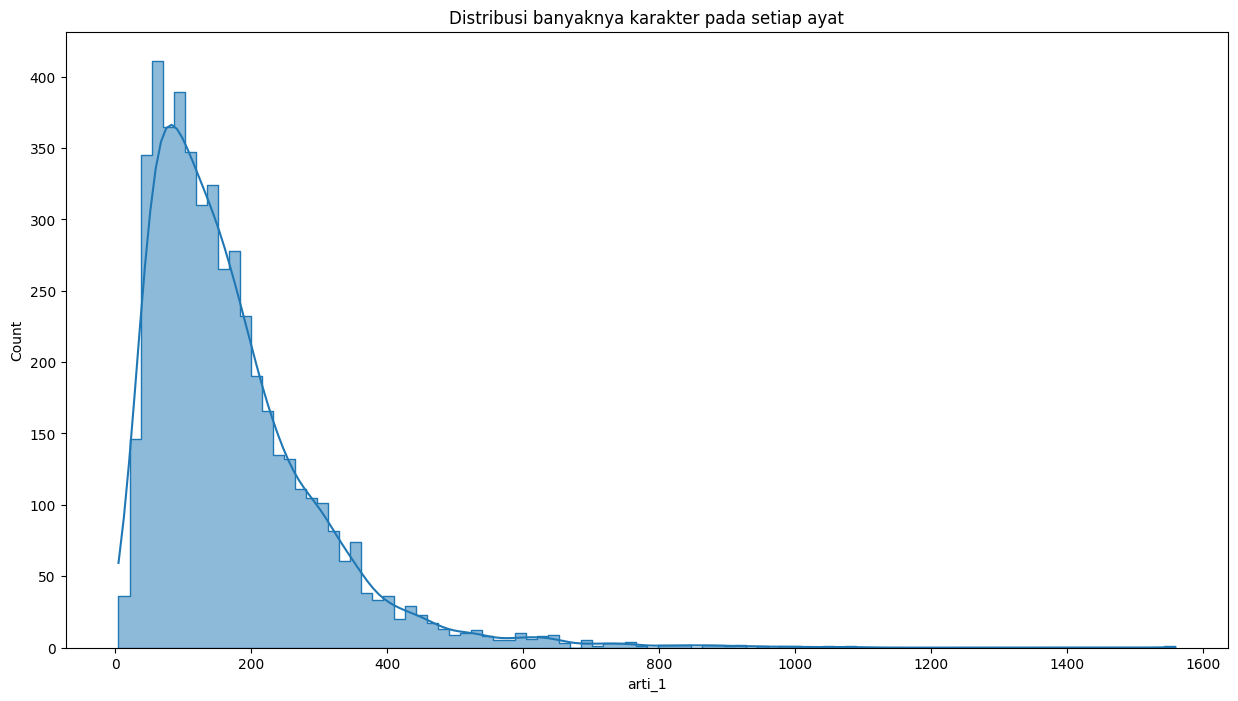

In [16]:
plt.figure(figsize=(15,8))
sns.histplot(data=df['arti_1'].str.len(), element='step', kde=True).set_title("Distribusi banyaknya karakter pada setiap ayat")

Text(0.5, 1.0, 'Distribusi banyaknya kata pada setiap ayat')

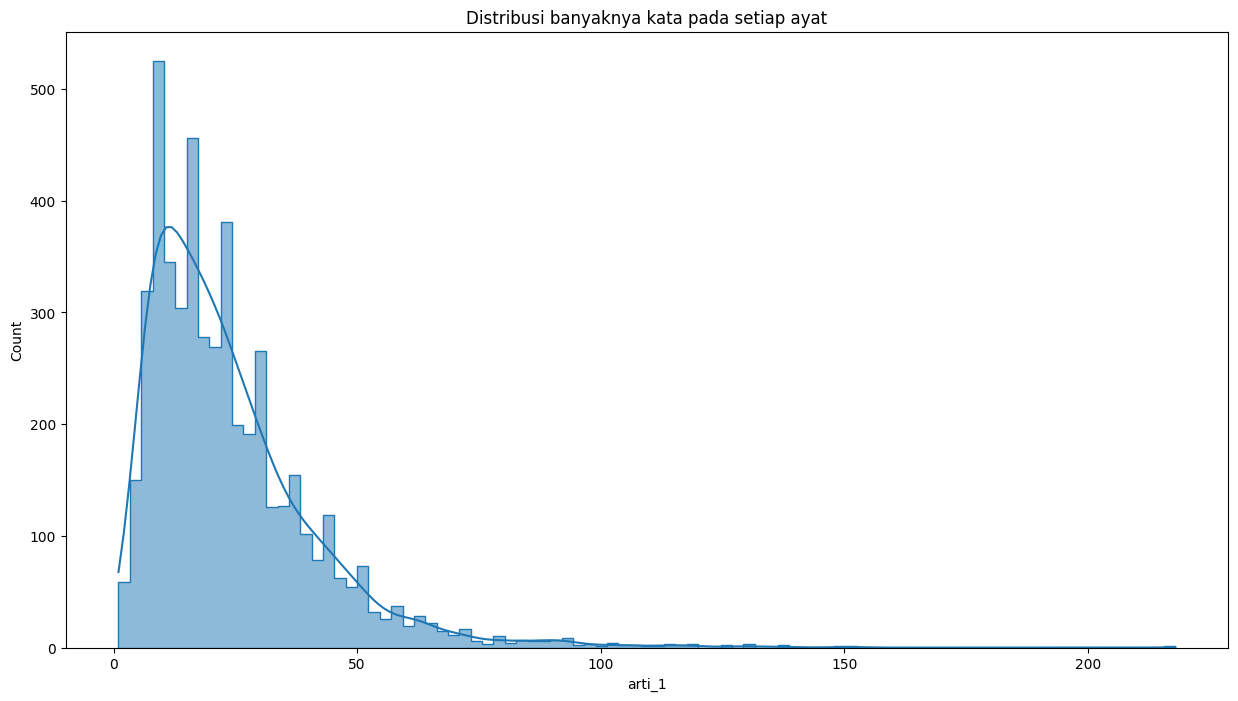

In [17]:
plt.figure(figsize=(15,8))
sns.histplot(data=df['arti_1'].str.split().map(lambda x: len(x)), element='step', kde=True).set_title("Distribusi banyaknya kata pada setiap ayat")

Text(0.5, 1.0, 'Distribusi rata-rata panjang kata pada setiap ayat')

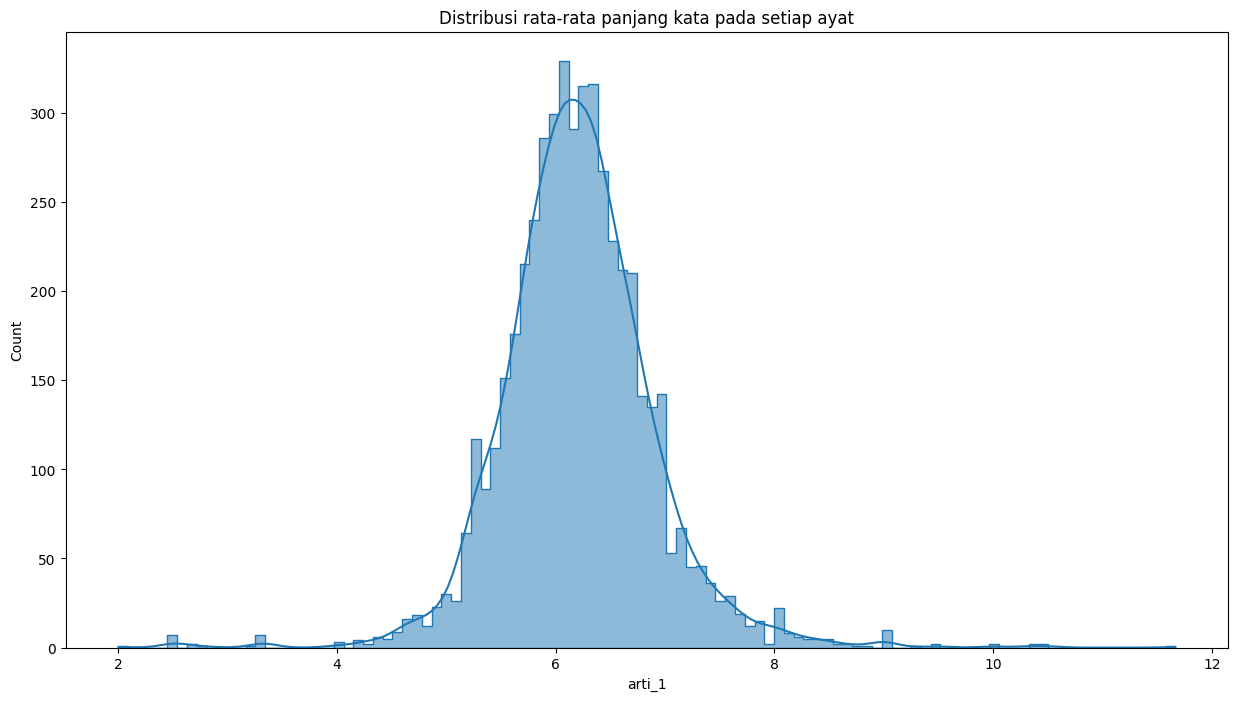

In [18]:
plt.figure(figsize=(15,8))
sns.histplot(data=df['arti_1'].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)), element='step', kde=True).set_title("Distribusi rata-rata panjang kata pada setiap ayat")

<b>Banyaknya stopword pada setiap ayat</b>

In [19]:
corpus_ayat = []
for x in df['arti_1'].str.split():
    for i in x:
        corpus_ayat.append(i)


temp = defaultdict(int)

for word in corpus_ayat:
    if word in stopwords_combine:
        temp[word] += 1

top = sorted(temp.items(), key=lambda x:x[1], reverse=True)[:10]

Text(0.5, 1.0, 'Banyaknya stopword')

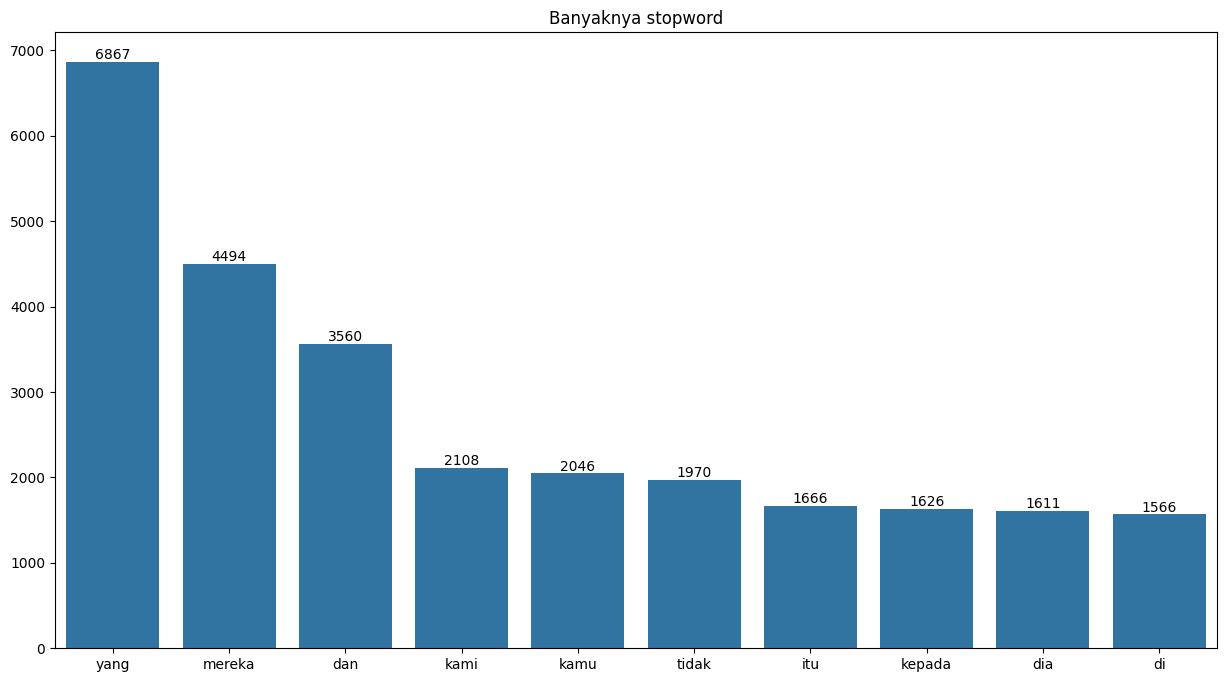

In [20]:
x, y = zip(*top)

plt.figure(figsize=(15,8))
ax = sns.barplot(x=x, y=y, estimator='sum')
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_title("Banyaknya stopword")

<p><b>Notes: </b></p>
<p>"yang" juga dapat diartikan juga sebagai "Yang Maha Kuasa", "Yang Maha Pengasih", dan lainnya. Begitu pun "kami", apakah "kami" manusia, atau "Kami" Allah. Dan juga "dia", apakah "dia" seseorang, atau '"dia" Allah, contoh: Dia tidak beranak dan tidak pula diperanakkan (QS. 114:3). Mudah-mudahan kita dapat memisahkan kata-kata tersebut pada versi selanjutnya</p>
<p><i>"yang" can also be interpreted as "the Almighty", "the Most Loving", and others. Likewise "us", whether "we" humans, or "We" God. And also "he", whether "he" is someone, or "he" Allah, for example: He does not beget nor is he begotten (QS. 114:3). Hopefully we can separate those words in the next version</i></p>

Text(0.5, 1.0, 'Total kata')

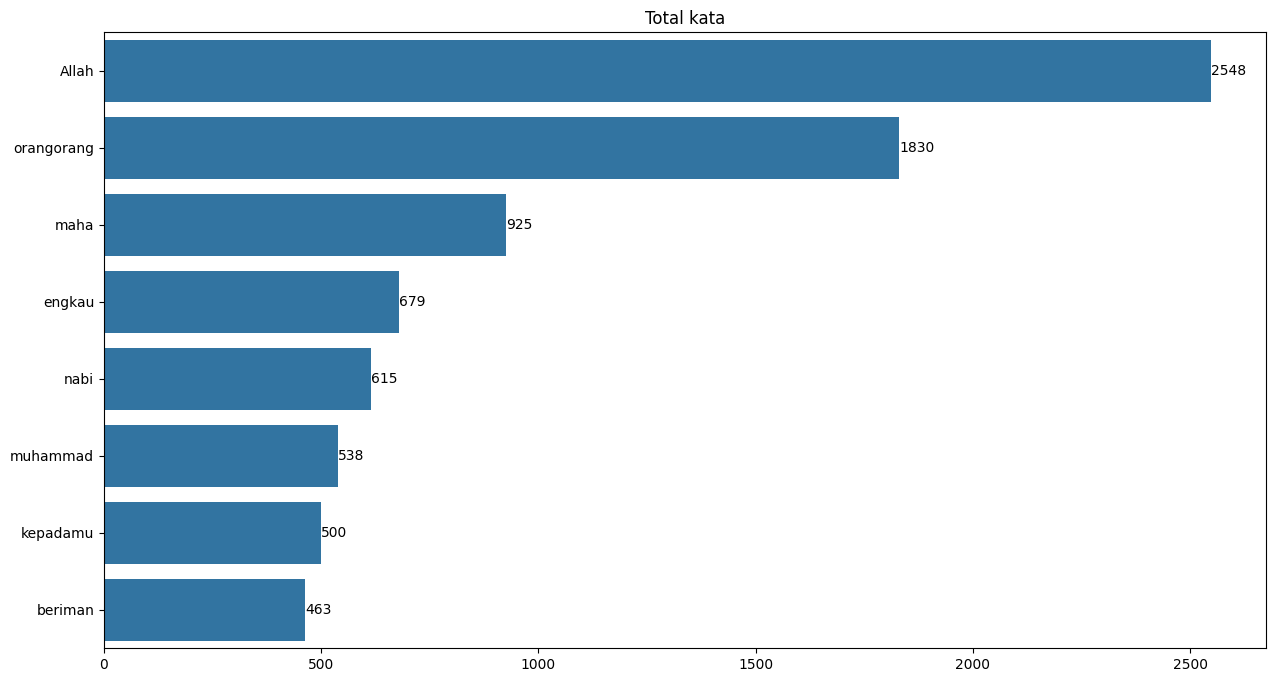

In [21]:
most = Counter(corpus_ayat).most_common()
x, y = [], [] 

for word, count in most[:40]:
    if word not in stopwords_combine:
        x.append(word)
        y.append(count)

plt.figure(figsize=(15,8))
ax = sns.barplot(x=y, y=x, orient='y')
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_title("Total kata")

## N-Gram
<p>Kita akan mencoba melakukan analisis n-gram, dengan n=2 (dua kata).</p>
<p><i>We will try to do n-gram analysis, with n=2 (two words).</i></p>

In [42]:
### fungsi bigram n=2
def top_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bow = vec.transform(corpus)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


Text(0.5, 1.0, 'Frekuensi Bigram')

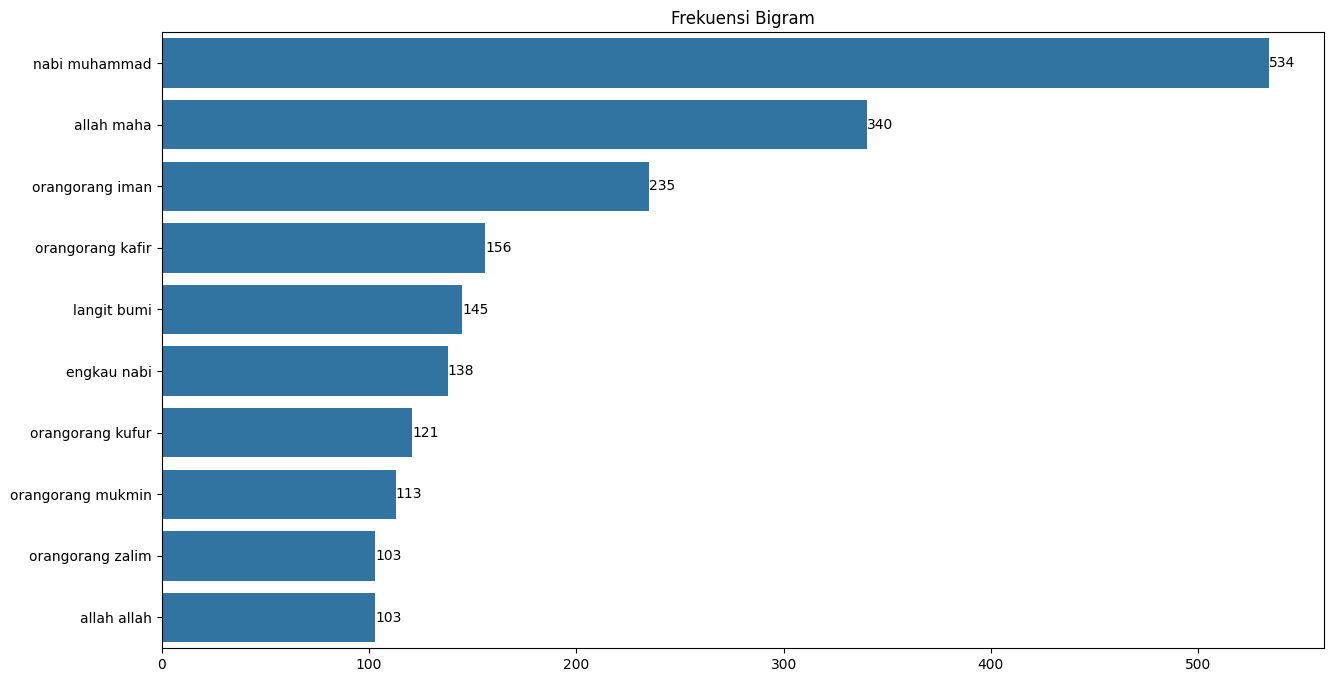

In [43]:
x, y = map(list, zip(*top_bigrams(df['after_lemma'])[0:10]))

plt.figure(figsize=(15,8))
ax = sns.barplot(x=y, y=x, orient='y')
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_title("Frekuensi Bigram")

## Wordcloud

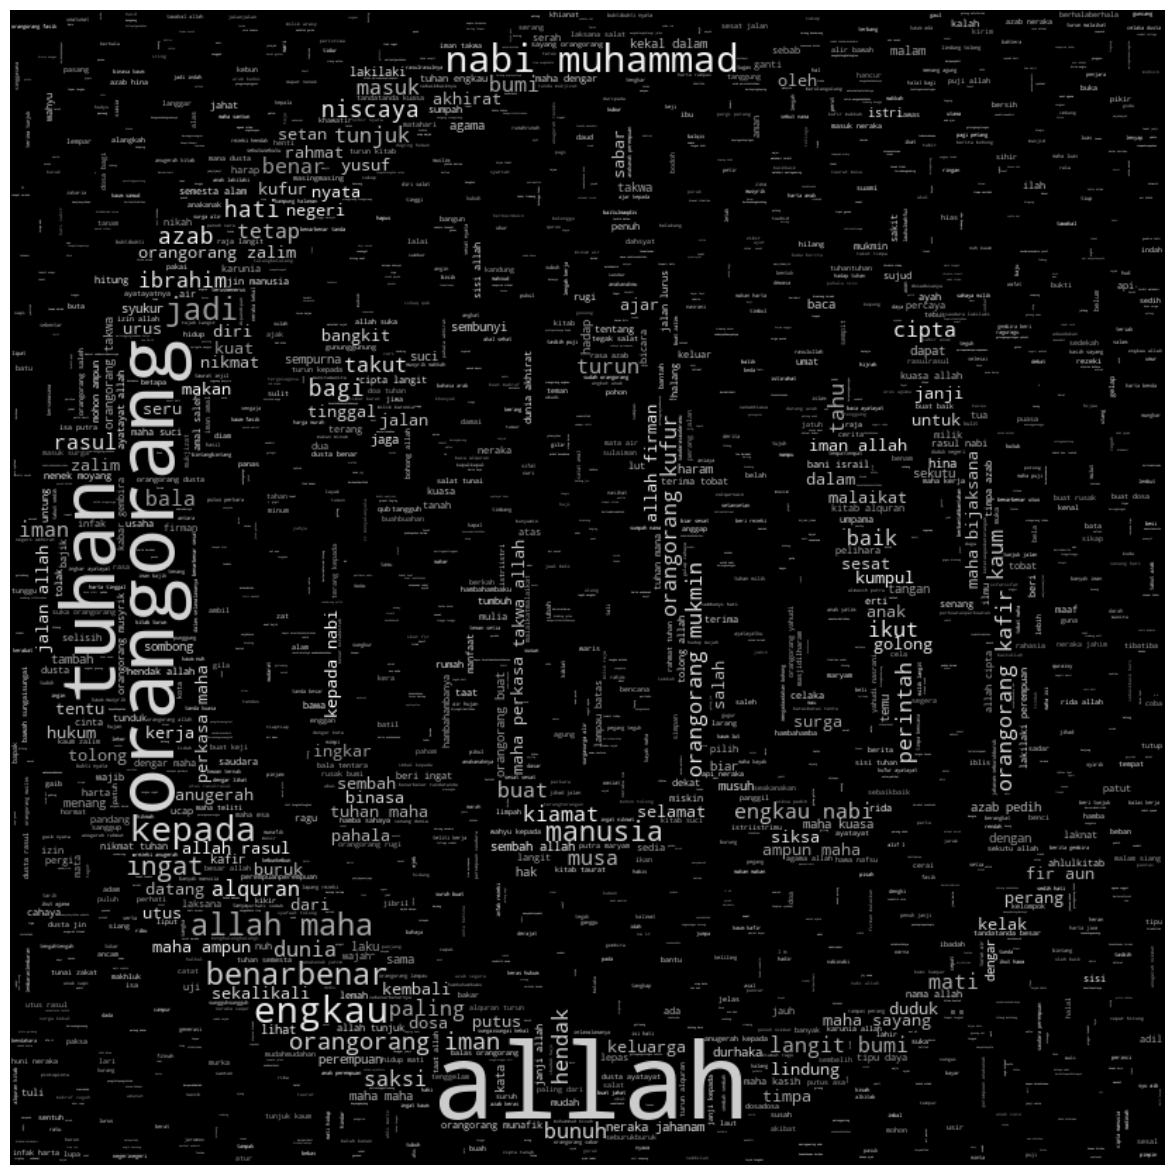

In [44]:
# Function for grey colour of cloud
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

# Function that makes the cloud
def make_cloud(x, url):
    response = requests.get(url) # Requesting the url for image
    mask = np.array(Image.open(BytesIO(response.content))) # Converting image to numpy array to make mask
    cloud = WordCloud(background_color='black',
                      width=5000, height=5000, 
                      max_words=2000, max_font_size=200, 
                      min_font_size=1, mask=mask, stopwords=STOPWORDS)
    cloud.generate(x) # Generating WordCloud
    
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(cloud.recolor(color_func=grey_color_func, random_state=3), interpolation='bilinear') # Adding grey colour
    ax.set_axis_off()
    
    plt.show(cloud)

make_cloud(" ".join(df['after_lemma'].values), "https://img.favpng.com/11/3/11/star-and-crescent-symbols-of-islam-islamic-calligraphy-allah-png-favpng-m7nBSrdy9LUq667UVHfuK5Fdz.jpg")

## Another analysis

In [45]:
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

In [46]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [47]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features
)

tfidf = tfidf_vectorizer.fit_transform(df['after_lemma'])

In [48]:
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features
)
tf = tf_vectorizer.fit_transform(df['after_lemma'])

### Topic Modeling

#### Non-Negative Matrix Factorization (NMF) Model

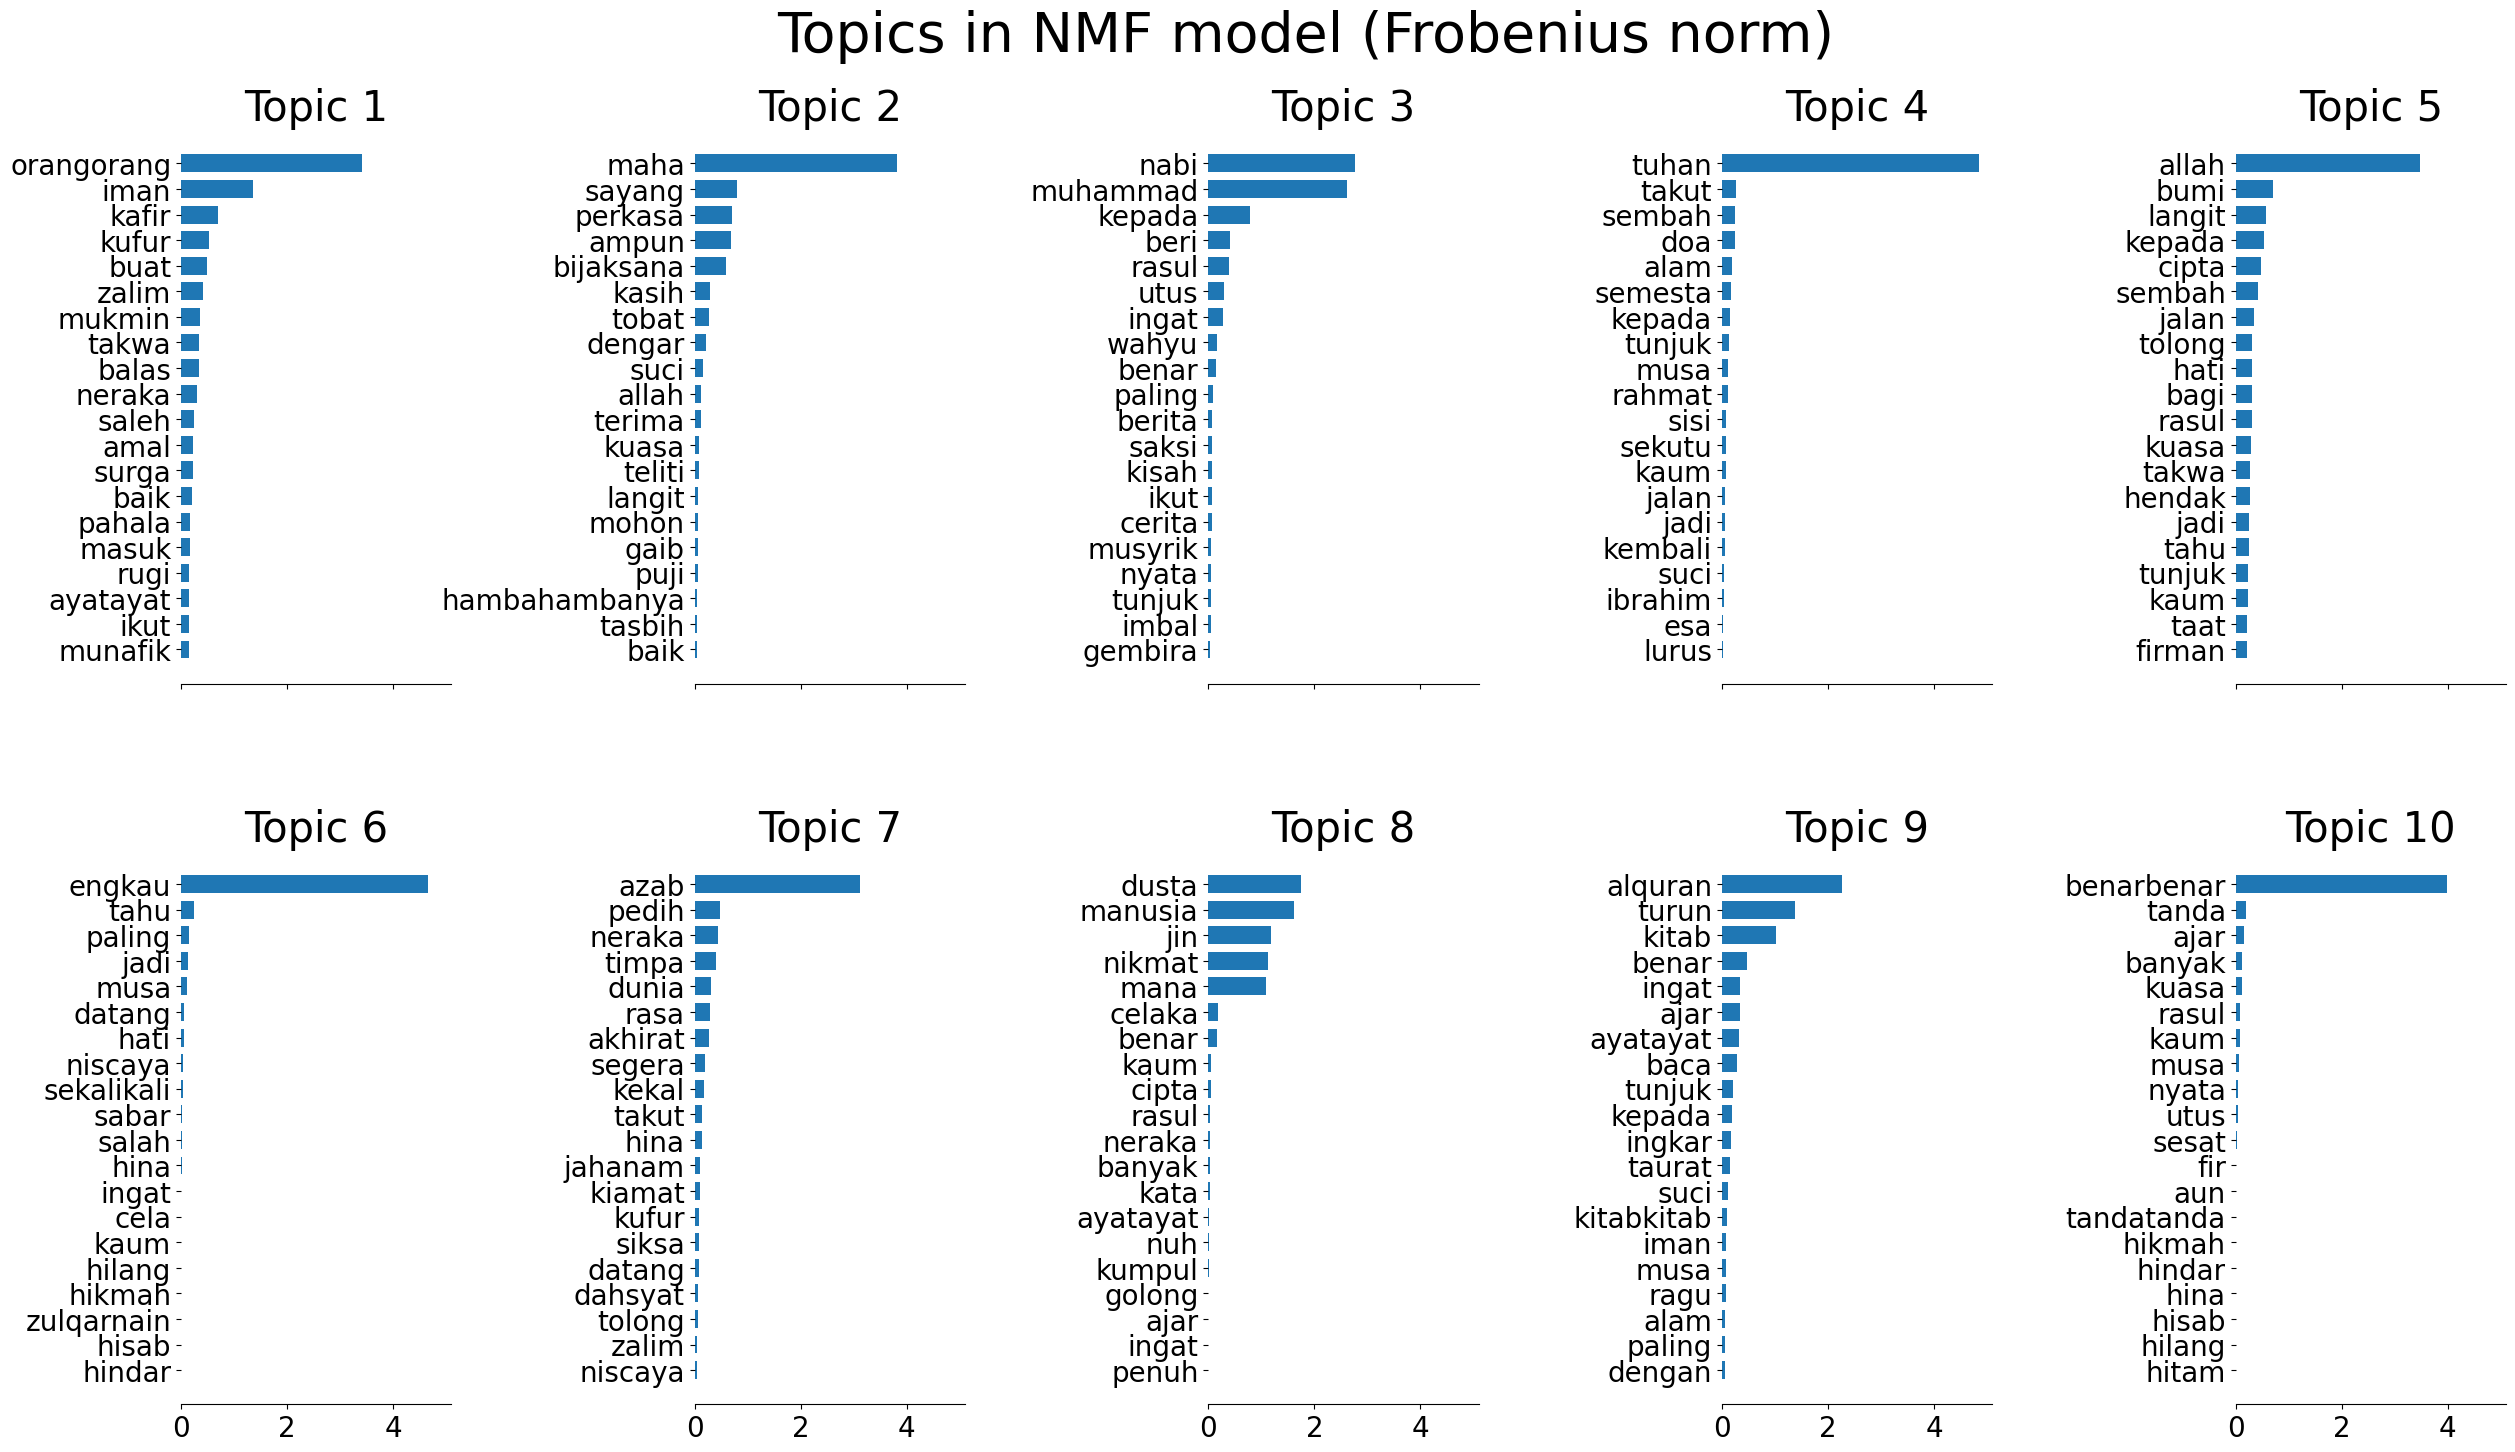

In [49]:
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

#### Mini Batch NMF Model

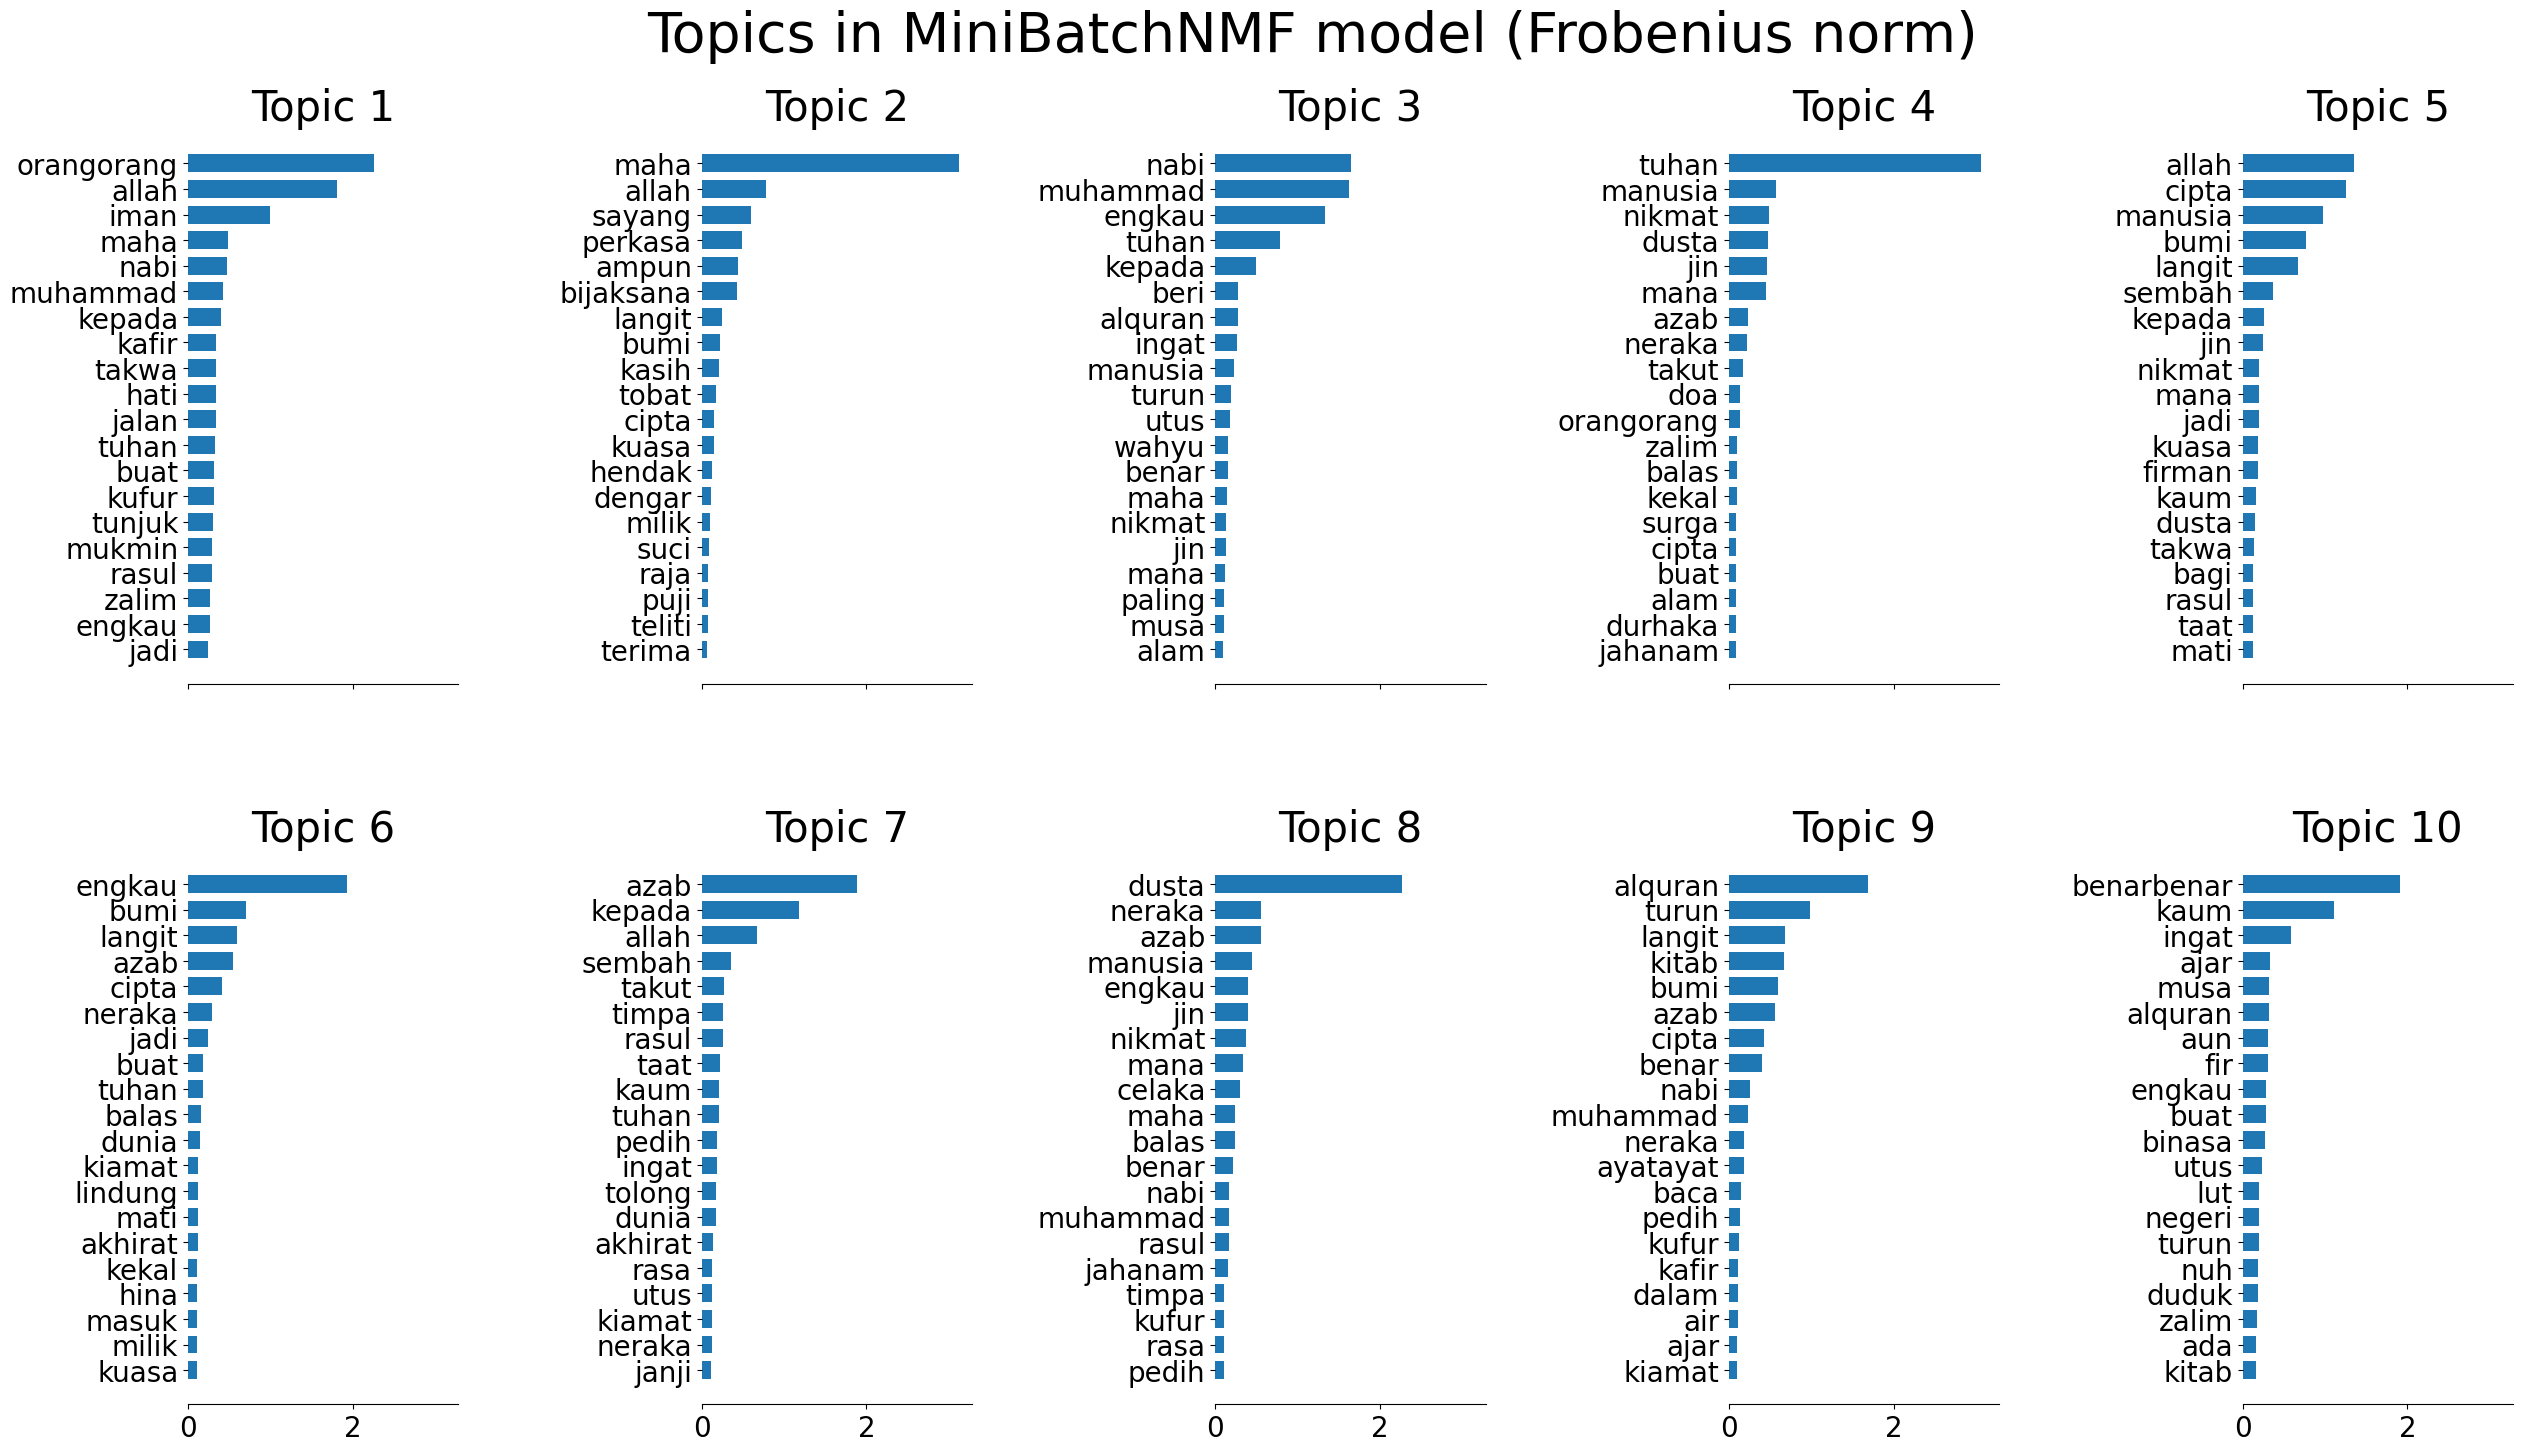

In [50]:
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

#### Latent Dirichclet Allocation (LDA) Model
<p><a href="https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/topic_coherence_tutorial.ipynb">Article 1</a></p>
<p><a href="https://medium.com/data-science/practical-guide-to-topic-modeling-with-lda-05cd6b027bdf">Article 2</a></p>

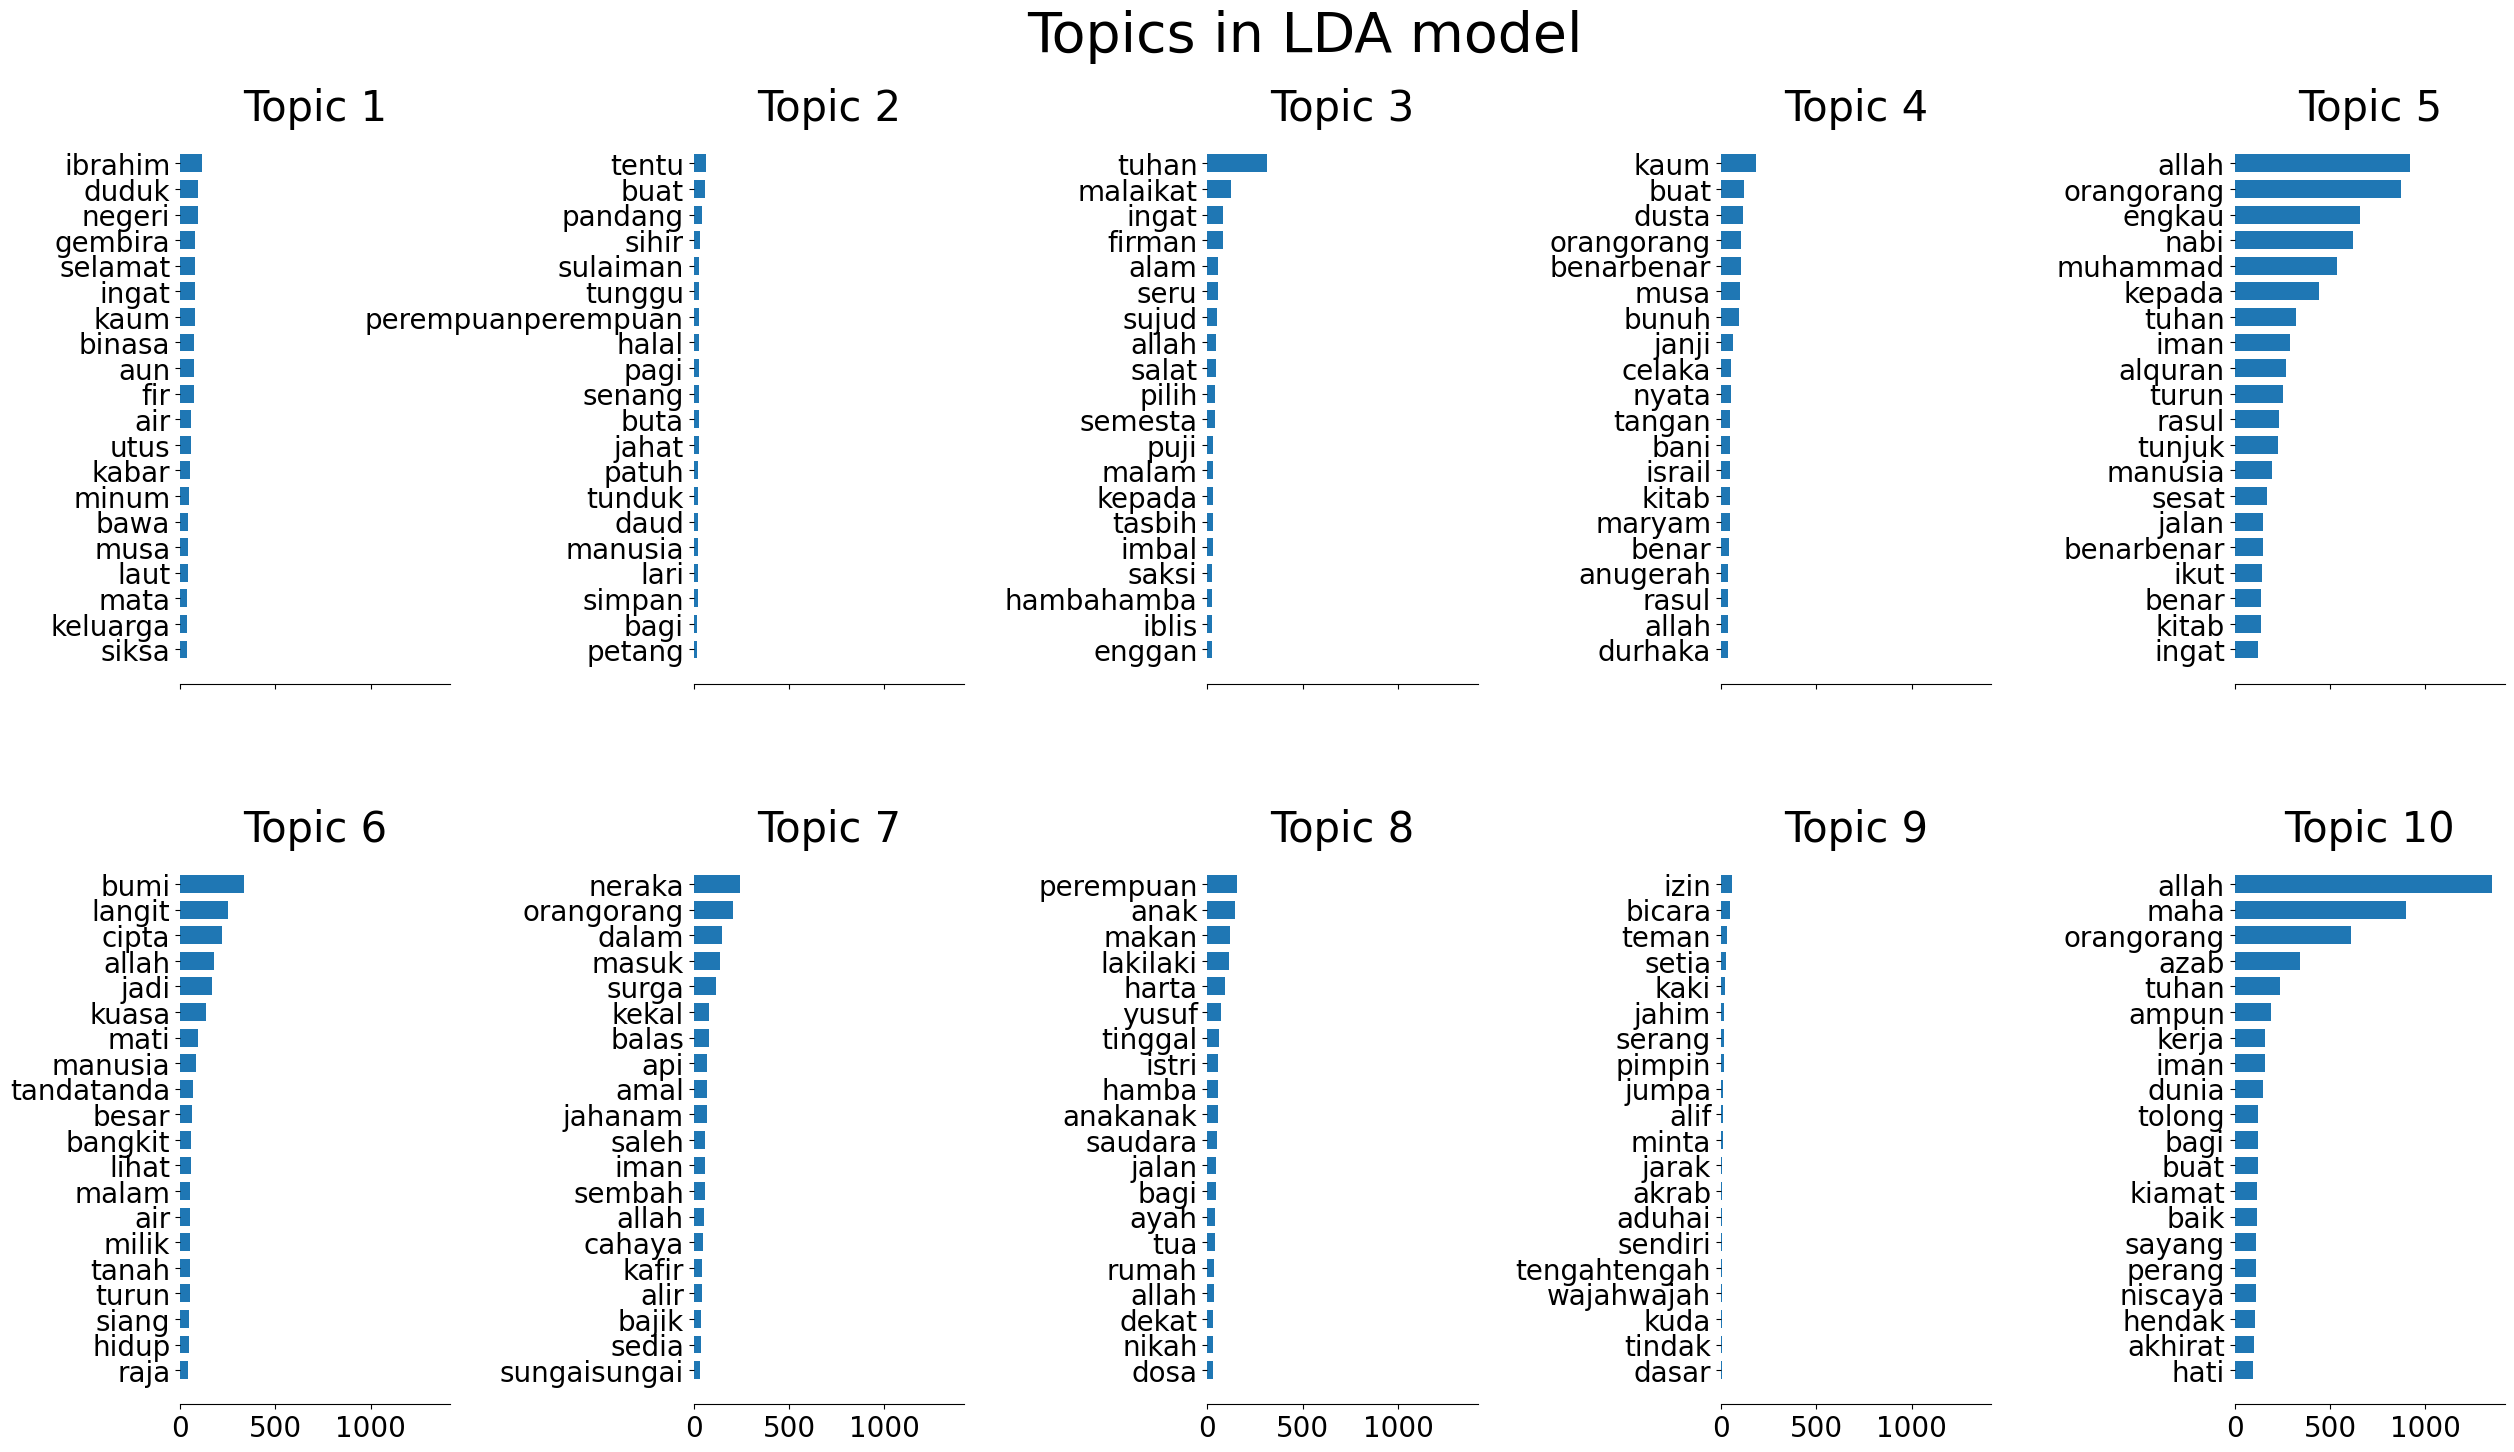

In [23]:
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=73,
    learning_method="online",
    learning_offset=103.0,
    random_state=0,
    learning_decay=0.79
)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

### Positive Negative (Sentiment) Analysis 
<p>Analisis ini bukan menunjukkan baik atau buruknya dari ayat-ayat Al-Qur'an, tetapi maksud dari positif atau negatif yaitu dalam ayat lebih banyak mengandung arti postif (menyenangkan, surga, dll) atau negatif (neraka, zuhud, dll).</p>
<p>Pada dasarnya sentiment analisis terbagi menjadi tiga jenis:</p>
<li>Lexicon</li>
<li>Machine learning</li>
<li>Hybrid</li>
<br>
<p><i>This analysis does not show whether the verses of the Qur'an are good or bad, but rather the positive or negative meaning, that is, the verses contain more positive meanings (pleasant, heaven, etc.) or negative (hell, asceticism, etc.).</i></p>
<p><i>Basically, sentiment analysis is divided into three types:</i></p>
<li>Lexicon</li>
<li>Machine learning</li>
<li>Hybrid</li>


#### Lexicon based
Kita menggunakan beberapa sumber:

<i>We use several sources:</i>

- <a href="https://www.kaggle.com/datasets/rtatman/sentiment-lexicons-for-81-languages">src 1</a>
- <a href="https://github.com/masdevid/ID-OpinionWords/tree/master">src 2</a>
- <a href="https://github.com/fajri91/InSet/tree/master">src 3</a>
- combination of all sources

In [3]:
lex_neg3 = dict()
a_word = pd.read_csv('DataSource/posneg_word/3/negative.tsv', sep='\t')['word'].to_list()
a_weight = pd.read_csv('DataSource/posneg_word/3/negative.tsv', sep='\t')['weight'].to_list()

lex_pos3 = dict()
b_word = pd.read_csv('DataSource/posneg_word/3/positive.tsv', sep='\t')['word'].to_list()
b_weight = pd.read_csv('DataSource/posneg_word/3/positive.tsv', sep='\t')['weight'].to_list()

for i in range(len(a_word)):
    lex_neg3[a_word[i]] = a_weight[i]

for i in range(len(b_word)):
    lex_pos3[b_word[i]] = b_weight[i]

In [5]:
lexicon_negative1 = []
with open('DataSource/posneg_word/1/sentiment-lexicons/negative_words_id.txt', 'r') as fd: 
    reader = csv.reader(fd)
    for row in reader:
        lexicon_negative1.append(row[0])

lexicon_positive1 = []
with open('DataSource/posneg_word/1/sentiment-lexicons/positive_words_id.txt', 'r') as fd: 
    reader = csv.reader(fd)
    for row in reader:
        lexicon_positive1.append(row[0])


lexicon_negative2 = []
with open('DataSource/posneg_word/2/negative.txt', 'r') as fd: 
    reader = csv.reader(fd)
    for row in reader:
        lexicon_negative2.append(row[0])

lexicon_positive2 = []
with open('DataSource/posneg_word/2/positive.txt', 'r') as fd: 
    reader = csv.reader(fd)
    for row in reader:
        lexicon_negative2.append(row[0])
        

# Combine the lists and convert to a set to remove duplicates
combined_set = set(lexicon_positive1 + lexicon_positive2 + b_word)

# Convert the set back to a list if a list is required
lexicon_postive_combine = list(combined_set)

# Combine the lists and convert to a set to remove duplicates
combined_set = set(lexicon_negative1 + lexicon_negative2 + a_word)

# Convert the set back to a list if a list is required
lexicon_negative_combine = list(combined_set)

In [6]:
"""
manual scoring function every source
"""

def posneg_1(text):
    score = 0
    for word in text:
        if (word in lexicon_positive1):
            score += 1
    for word in text:
        if (word in lexicon_negative1):
            score -= 1
    polarity=''
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity

def posneg_2(text):
    score = 0
    for word in text:
        if (word in lexicon_positive2):
            score += 1
    for word in text:
        if (word in lexicon_negative2):
            score -= 1
    polarity=''
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity

def posneg_3(text):
    score = 0
    for word in text:
        if (word in lex_pos3):
            score += lex_pos3[word]
    for word in text:
        if (word in lex_neg3):
            score += lex_neg3[word]
    polarity=''
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity

def posneg_combine(text):
    score = 0
    for word in text:
        if (word in lexicon_postive_combine):
            score += 1
    for word in text:
        if (word in lexicon_negative_combine):
            score -= 1
    polarity=''
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity

In [7]:
results1 = list(zip(*df['after_lemma'].apply(lambda x: posneg_1(x.split()))))
results2 = list(zip(*df['after_lemma'].apply(lambda x: posneg_2(x.split()))))
results3 = list(zip(*df['after_lemma'].apply(lambda x: posneg_3(x.split()))))
results_combine = list(zip(*df['after_lemma'].apply(lambda x: posneg_combine(x.split()))))

In [9]:
df['posneg_score_1'] = results1[0]
df['posneg_pol_1'] = results1[1]

df['posneg_score_2'] = results2[0]
df['posneg_pol_2'] = results2[1]

df['posneg_score_3'] = results3[0]
df['posneg_pol_3'] = results3[1]

df['posneg_score_combine'] = results_combine[0]
df['posneg_pol_combine'] = results_combine[1]

### save for analysis
df.to_pickle('df_ayat1.pkl')

<Axes: xlabel='variable', ylabel='count'>

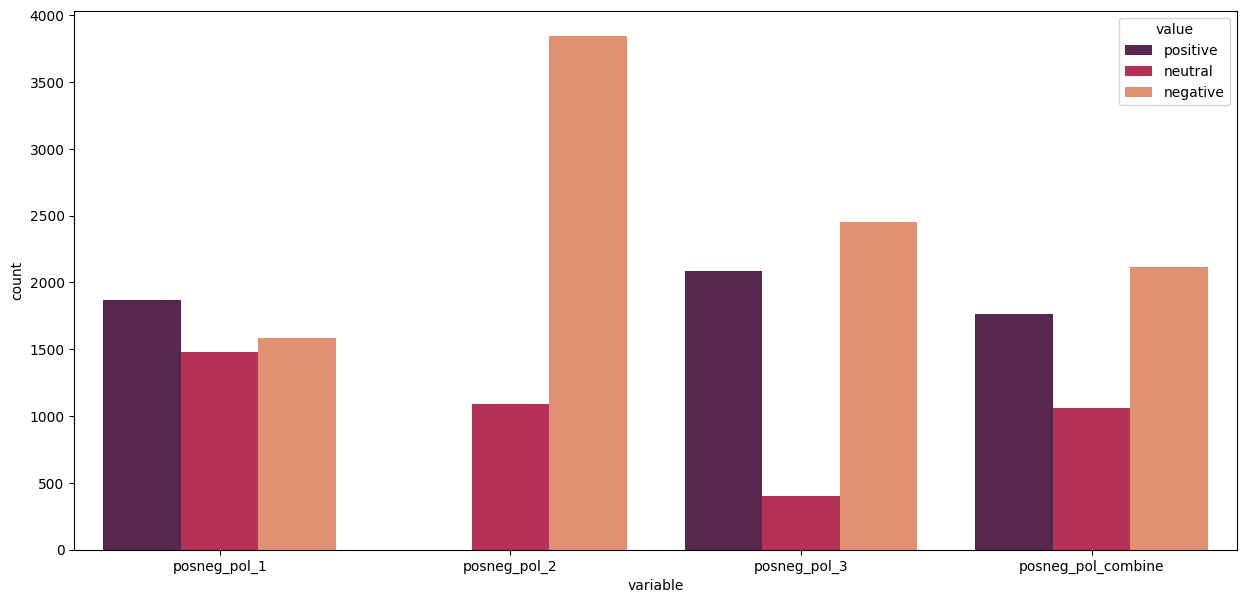

In [22]:
plt.figure(figsize=(15,7))
sns.countplot(x="variable", hue="value", data=pd.melt(df[['posneg_pol_1', 'posneg_pol_2', 'posneg_pol_3', 'posneg_pol_combine']]), palette='rocket')

#### Machine learning based

In [ ]:
## Next game

#### Hybrid based

In [ ]:
## Next game

# Kesimpulan
Alhamdulillah...

Kita dapat melihat beberapa hasil analisa yang telah dilakukan. Mudah-mudahan kita dapat melanjutkan analisa lainnya sehingga dapat menambah pengetahuan. Bisa juga untuk menggunakan arti dalam bahasa Inggris sehingga dapat menjadi perbandingan dengan bahasa Indonesia.

Semoga bermanfaat, terimakasih, sehat-sehat kawan, wassalam. CMIIW

In [25]:
!pip freeze -> req.txt